In [1]:
%matplotlib inline

In [2]:
feature_file_name = "vgg_features.pkl"
history_file_name = "model_run_history.pkl"
best_epoch_filename = "model-ep005-loss3.444-val_loss3.823.h5"

In [3]:
import pickle

from utils.plothist import plot
from utils.helpers import Config 

from utils.eval import prepare_evaluate_params, demo_captions, evaluate_model, predict_img


from keras.models import Model, load_model

c = Config() 


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
history = pickle.load(open(c.ExtractedFeaturesFilePath(history_file_name), "rb"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


dict_keys(['val_loss', 'loss'])


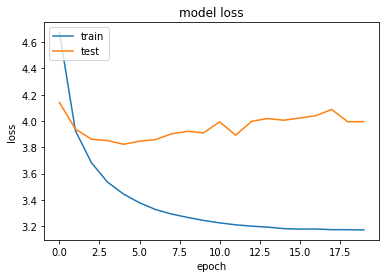

In [5]:
plot(history)

Now working on loading a model from h5 to evaluate 

https://machinelearningmastery.com/save-load-keras-deep-learning-models/


# model evaluation 

In this section we run the following tests: 
- BLEU scoring
- Qualitative test on demo_list
- BYO predictions


## load the model and evaluate

In this section, the best performing epoch run is loaded from the h5 file. 

then test data set is prepared for evaluation, the test data set was not seen before by the model during the training process.
to prepare the test data set: 
- load the test image ids `load_set(Flickr_8k.testImages)`
- load the photo features for test images `load_photo_features(vgg_features, test)`
- load clean descriptions for test images `load_clean_descrptions(descriptions, test)`
- load the tokenizer 
- set the max length to match input_2 dimension of the trained model (34 in the case of the first base model) 

them rum te evaluate_model function with all the above paramters. 

TODO: i will refactor this in a helper function to make it easier to just do the evaluation by passing in the loaded model, and some identifier for the test set

In [6]:
model = load_model(best_epoch_filename)


In [7]:
## note from the model summary how input_2 is of dim (,34) -> when validating or predicting, the input sequence length has to be maxed to 34
tokenizer, test_features, test_descriptions, max_length = prepare_evaluate_params(c, model, feature_file_name)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 

## BLEU Eval

In [8]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.422166
BLEU-2: 0.231111
BLEU-3: 0.155849
BLEU-4: 0.070362


## use the model to make predictions on test images

this step produces sample captions on on select set of test images, this is the AJ test. 

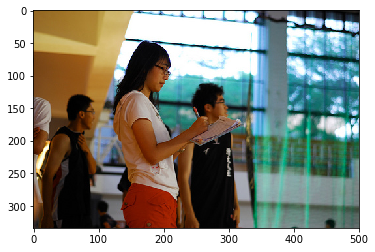

startseq man in red shirt is sitting on bench endseq


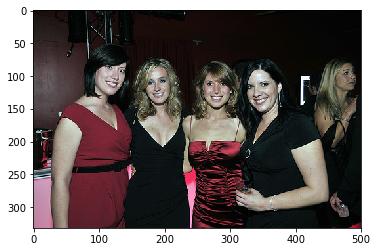

startseq man in red shirt is wearing red shirt and blue shirt and blue shirt endseq


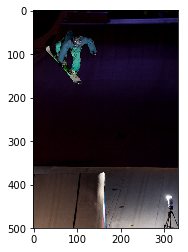

startseq two people are sitting on bench endseq


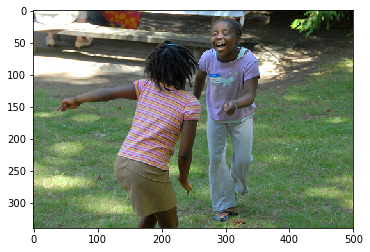

startseq two girls are playing in the water endseq


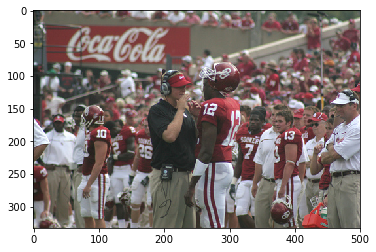

startseq two men in red shirts are playing basketball endseq


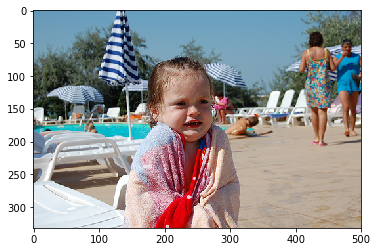

startseq man in red shirt is sitting on bench endseq


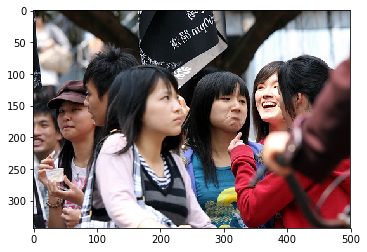

startseq two people are sitting on bench endseq


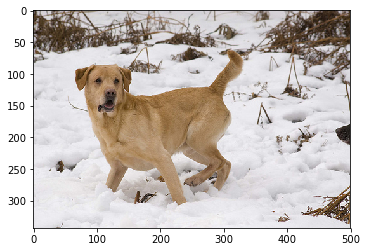

startseq black dog is running through the snow endseq


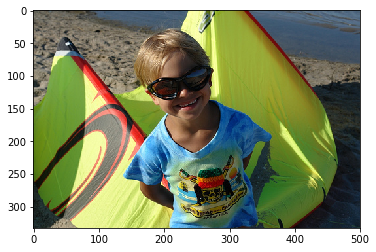

startseq man in red shirt is standing on the beach endseq


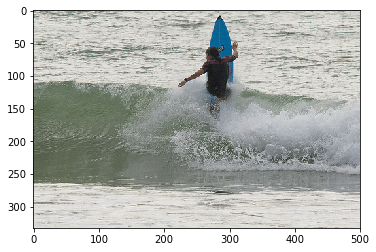

startseq man in blue suit is surfing in the ocean endseq


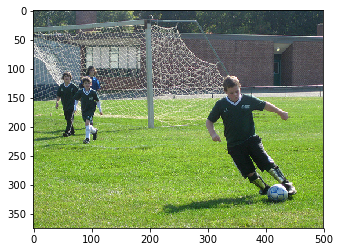

startseq two men playing soccer in the grass endseq


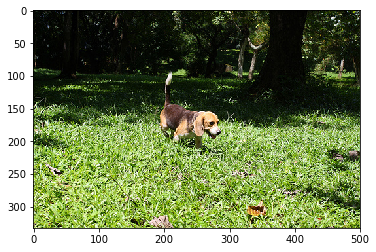

startseq black and white dog is running through the grass endseq


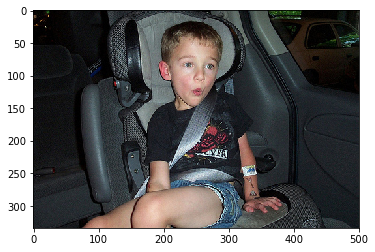

startseq two young women in white clothes are sitting on the bench endseq


In [9]:
demo_captions(c, model, test_features, tokenizer, test_descriptions, max_length)

# Bring your own image

In [10]:
# prepare the photo input 
demo_path = c.flickr_images_directory + "/"
img_filepath = demo_path + "1015118661_980735411b.jpg"
#img_filepath = "user/mutaz/car1.jpg"

In [11]:
import keras.applications.vgg16 as vgg16

keras_app = vgg16
# load a cnn model to examine the classification
cnn_model = vgg16.VGG16()


In [12]:
# load a cnn feature representation model, this one is used for producing input to the captioning model 
cnn_model_features =  vgg16.VGG16()
cnn_model_features.layers.pop()
cnn_model_features = Model(inputs=cnn_model_features.inputs, outputs=cnn_model_features.layers[-1].output)

jean (7.24%)
[[('n03594734', 'jean', 0.07238187), ('n02825657', 'bell_cote', 0.05514789), ('n06794110', 'street_sign', 0.04264572), ('n03770439', 'miniskirt', 0.042494897), ('n03763968', 'military_uniform', 0.03746451)]]
0>> startseq two
1>> startseq two girls
2>> startseq two girls are
3>> startseq two girls are playing
4>> startseq two girls are playing with
5>> startseq two girls are playing with the
6>> startseq two girls are playing with the camera
7>> startseq two girls are playing with the camera endseq


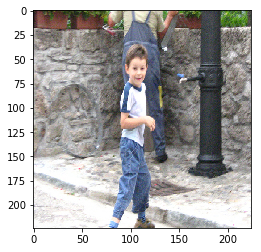

CNN model classification: jean (7.24%)
caption: startseq two girls are playing with the camera endseq


In [13]:
predict_img(model, tokenizer, max_length, img_filepath, cnn_model, cnn_model_features, keras_app, target_size = (224,224))


sports_car (31.95%)
[[('n04285008', 'sports_car', 0.31947023), ('n02930766', 'cab', 0.31244043), ('n04037443', 'racer', 0.11982075), ('n03100240', 'convertible', 0.095948614), ('n03670208', 'limousine', 0.06879611)]]
0>> startseq man
1>> startseq man in
2>> startseq man in red
3>> startseq man in red shirt
4>> startseq man in red shirt is
5>> startseq man in red shirt is standing
6>> startseq man in red shirt is standing on
7>> startseq man in red shirt is standing on the
8>> startseq man in red shirt is standing on the street
9>> startseq man in red shirt is standing on the street endseq


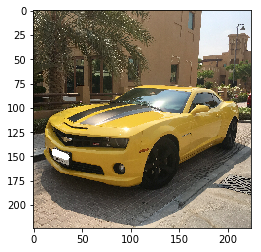

CNN model classification: sports_car (31.95%)
caption: startseq man in red shirt is standing on the street endseq


In [14]:
predict_img(model, tokenizer, max_length, "user/mutaz/car1.jpg", cnn_model, cnn_model_features, keras_app, target_size = (224,224))


limousine (33.50%)
[[('n03670208', 'limousine', 0.3350476), ('n03100240', 'convertible', 0.19775897), ('n03770679', 'minivan', 0.09117153), ('n03594945', 'jeep', 0.06492834), ('n02814533', 'beach_wagon', 0.064443715)]]
0>> startseq man
1>> startseq man in
2>> startseq man in blue
3>> startseq man in blue shirt
4>> startseq man in blue shirt is
5>> startseq man in blue shirt is standing
6>> startseq man in blue shirt is standing on
7>> startseq man in blue shirt is standing on the
8>> startseq man in blue shirt is standing on the street
9>> startseq man in blue shirt is standing on the street endseq


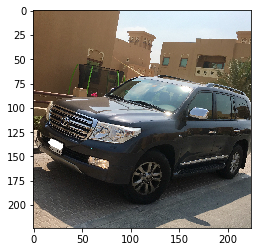

CNN model classification: limousine (33.50%)
caption: startseq man in blue shirt is standing on the street endseq


In [15]:
predict_img(model, tokenizer, max_length, "user/mutaz/suv1.jpg", cnn_model, cnn_model_features, keras_app, target_size = (224,224))


mountain_bike (47.97%)
[[('n03792782', 'mountain_bike', 0.47972447), ('n09193705', 'alp', 0.12430314), ('n09468604', 'valley', 0.07391448), ('n02835271', 'bicycle-built-for-two', 0.05570415), ('n09246464', 'cliff', 0.051877335)]]
0>> startseq man
1>> startseq man in
2>> startseq man in red
3>> startseq man in red shirt
4>> startseq man in red shirt is
5>> startseq man in red shirt is standing
6>> startseq man in red shirt is standing on
7>> startseq man in red shirt is standing on the
8>> startseq man in red shirt is standing on the street
9>> startseq man in red shirt is standing on the street endseq


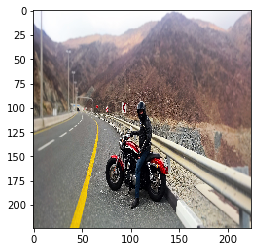

CNN model classification: mountain_bike (47.97%)
caption: startseq man in red shirt is standing on the street endseq


In [16]:
predict_img(model, tokenizer, max_length, "user/mutaz/bike1.jpg", cnn_model, cnn_model_features, keras_app, target_size = (224,224))
